# Peter und der Wolf: Einführung in Reinforcement Learning

In diesem Tutorial lernen wir, wie man Reinforcement Learning auf ein Problem der Wegfindung anwendet. Das Szenario ist inspiriert von [Peter und der Wolf](https://en.wikipedia.org/wiki/Peter_and_the_Wolf), einem musikalischen Märchen des russischen Komponisten [Sergei Prokofiev](https://en.wikipedia.org/wiki/Sergei_Prokofiev). Es ist die Geschichte des jungen Pioniers Peter, der mutig sein Haus verlässt, um auf der Waldlichtung den Wolf zu jagen. Wir werden maschinelle Lernalgorithmen trainieren, die Peter dabei helfen, die Umgebung zu erkunden und eine optimale Navigationskarte zu erstellen.

Zuerst importieren wir eine Reihe nützlicher Bibliotheken:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## Überblick über Reinforcement Learning

**Reinforcement Learning** (RL) ist eine Lerntechnik, die es uns ermöglicht, das optimale Verhalten eines **Agenten** in einer bestimmten **Umgebung** durch das Durchführen vieler Experimente zu erlernen. Ein Agent in dieser Umgebung sollte ein **Ziel** haben, das durch eine **Belohnungsfunktion** definiert ist.

## Die Umgebung

Zur Vereinfachung nehmen wir an, dass Peters Welt ein quadratisches Spielfeld der Größe `width` x `height` ist. Jede Zelle auf diesem Spielfeld kann entweder sein:
* **Boden**, auf dem Peter und andere Kreaturen laufen können
* **Wasser**, auf dem man offensichtlich nicht laufen kann
* **ein Baum** oder **Gras** – ein Ort, an dem man sich ausruhen kann
* **ein Apfel**, der etwas darstellt, das Peter gerne finden würde, um sich zu ernähren
* **ein Wolf**, der gefährlich ist und vermieden werden sollte

Um mit der Umgebung zu arbeiten, definieren wir eine Klasse namens `Board`. Um dieses Notebook nicht zu überladen, haben wir den gesamten Code, der mit dem Spielfeld arbeitet, in ein separates Modul namens `rlboard` ausgelagert, das wir nun importieren. Sie können einen Blick in dieses Modul werfen, um mehr Details über die interne Implementierung zu erfahren.


In [2]:
from rlboard import *

Lassen Sie uns nun ein zufälliges Brett erstellen und sehen, wie es aussieht:


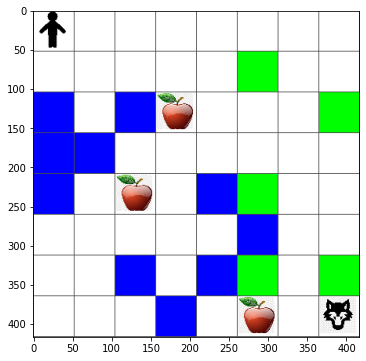

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## Aktionen und Richtlinien

In unserem Beispiel besteht Peters Ziel darin, einen Apfel zu finden, während er dem Wolf und anderen Hindernissen ausweicht. Um dies zu erreichen, kann er im Grunde herumlaufen, bis er einen Apfel findet. An jeder Position kann er daher eine der folgenden Aktionen wählen: nach oben, nach unten, nach links und nach rechts. Wir werden diese Aktionen als ein Wörterbuch definieren und sie mit Paaren von entsprechenden Koordinatenänderungen verknüpfen. Zum Beispiel würde die Bewegung nach rechts (`R`) einem Paar `(1,0)` entsprechen.


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

Die Strategie unseres Agenten (Peter) wird durch eine sogenannte **Policy** definiert. Betrachten wir die einfachste Policy, die als **Zufallsbewegung** bezeichnet wird.

## Zufallsbewegung

Lassen Sie uns zunächst unser Problem lösen, indem wir eine Strategie der Zufallsbewegung implementieren.


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

Lassen Sie uns das Random-Walk-Experiment mehrmals durchführen und die durchschnittliche Anzahl der Schritte betrachten:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## Belohnungsfunktion

Um unsere Strategie intelligenter zu machen, müssen wir verstehen, welche Züge "besser" sind als andere.


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## Q-Learning

Erstellen Sie eine Q-Tabelle oder ein mehrdimensionales Array. Da unser Spielfeld die Dimensionen `width` x `height` hat, können wir die Q-Tabelle durch ein numpy-Array mit der Form `width` x `height` x `len(actions)` darstellen:


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Übergeben Sie die Q-Tabelle an die Plot-Funktion, um die Tabelle auf dem Brett zu visualisieren:


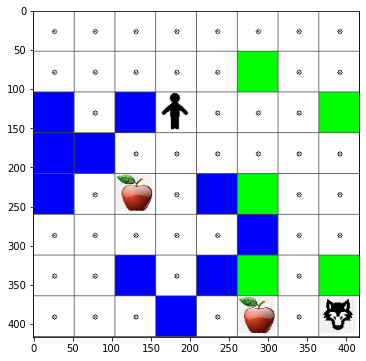

In [9]:
m.plot(Q)

## Essenz des Q-Learning: Bellman-Gleichung und Lernalgorithmus

Schreiben Sie einen Pseudocode für unseren Lernalgorithmus:

* Initialisiere die Q-Tabelle Q mit gleichen Werten für alle Zustände und Aktionen
* Setze die Lernrate $\alpha\leftarrow 1$
* Wiederhole die Simulation viele Male
   1. Starte an einer zufälligen Position
   1. Wiederhole
        1. Wähle eine Aktion $a$ im Zustand $s$
        2. Führe die Aktion aus, indem du zu einem neuen Zustand $s'$ wechselst
        3. Wenn wir eine Spielende-Bedingung erreichen oder die Gesamtbelohnung zu klein ist - beende die Simulation  
        4. Berechne die Belohnung $r$ im neuen Zustand
        5. Aktualisiere die Q-Funktion gemäß der Bellman-Gleichung: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. Aktualisiere die Gesamtbelohnung und verringere $\alpha$.

## Ausnutzen vs. Erkunden

Der beste Ansatz ist, ein Gleichgewicht zwischen Erkundung und Ausnutzung zu finden. Während wir mehr über unsere Umgebung lernen, werden wir eher dazu neigen, den optimalen Weg zu folgen, jedoch gelegentlich auch den unerforschten Pfad wählen.

## Python-Implementierung

Nun sind wir bereit, den Lernalgorithmus zu implementieren. Zuvor benötigen wir jedoch eine Funktion, die beliebige Zahlen in der Q-Tabelle in einen Wahrscheinlichkeitsvektor für die entsprechenden Aktionen umwandelt:


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

Wir fügen dem ursprünglichen Vektor eine kleine Menge `eps` hinzu, um eine Division durch 0 im Anfangsfall zu vermeiden, wenn alle Komponenten des Vektors identisch sind.

Der eigentliche Lernalgorithmus, den wir für 5000 Experimente ausführen werden, auch **Epochen** genannt:


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

Nach der Ausführung dieses Algorithmus sollte die Q-Tabelle mit Werten aktualisiert werden, die die Attraktivität verschiedener Aktionen in jedem Schritt definieren. Visualisieren Sie die Tabelle hier:


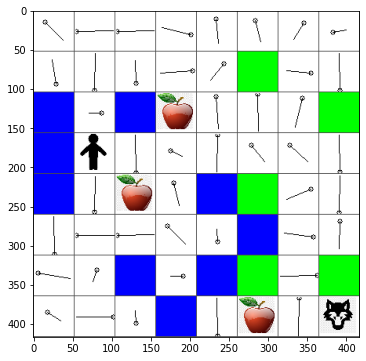

In [12]:
m.plot(Q)

## Überprüfung der Richtlinie

Da die Q-Tabelle die "Attraktivität" jeder Aktion in jedem Zustand auflistet, ist es ziemlich einfach, sie zu verwenden, um die effiziente Navigation in unserer Welt zu definieren. Im einfachsten Fall können wir einfach die Aktion auswählen, die dem höchsten Wert in der Q-Tabelle entspricht:


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

Wenn Sie den obigen Code mehrmals ausprobieren, werden Sie feststellen, dass er manchmal einfach "hängt" und Sie die STOP-Taste im Notebook drücken müssen, um ihn zu unterbrechen.

> **Aufgabe 1:** Ändern Sie die `walk`-Funktion so, dass die maximale Pfadlänge auf eine bestimmte Anzahl von Schritten (z. B. 100) begrenzt wird, und beobachten Sie, wie der obige Code diesen Wert von Zeit zu Zeit zurückgibt.

> **Aufgabe 2:** Ändern Sie die `walk`-Funktion so, dass sie nicht an Orte zurückkehrt, an denen sie zuvor bereits gewesen ist. Dies wird verhindern, dass `walk` in einer Schleife hängen bleibt. Allerdings kann es dennoch passieren, dass der Agent an einem Ort "gefangen" wird, von dem er nicht mehr entkommen kann.


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


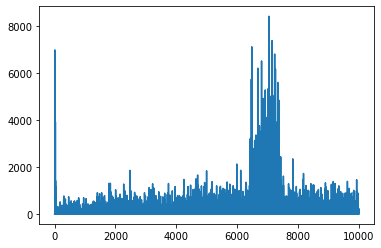

In [15]:
plt.plot(lpath)

Was wir hier sehen, ist, dass die durchschnittliche Pfadlänge zunächst zugenommen hat. Dies liegt wahrscheinlich daran, dass wir, wenn wir nichts über die Umgebung wissen, dazu neigen, in schlechten Zuständen, Wasser oder bei einem Wolf, gefangen zu werden. Sobald wir mehr lernen und dieses Wissen nutzen, können wir die Umgebung länger erkunden, aber wir wissen immer noch nicht genau, wo sich die Äpfel befinden.

Sobald wir genug gelernt haben, wird es für den Agenten einfacher, das Ziel zu erreichen, und die Pfadlänge beginnt zu sinken. Allerdings sind wir weiterhin offen für Erkundungen, sodass wir oft vom besten Weg abweichen und neue Optionen ausprobieren, was den Pfad länger als optimal macht.

Was wir auf diesem Diagramm ebenfalls beobachten, ist, dass die Länge an einem bestimmten Punkt plötzlich zugenommen hat. Dies deutet auf die stochastische Natur des Prozesses hin und darauf, dass wir die Q-Tabellen-Koeffizienten zu einem bestimmten Zeitpunkt „verderben“ können, indem wir sie mit neuen Werten überschreiben. Dies sollte idealerweise minimiert werden, indem die Lernrate verringert wird (d. h. gegen Ende des Trainings passen wir die Q-Tabellen-Werte nur noch geringfügig an).

Insgesamt ist es wichtig, sich daran zu erinnern, dass der Erfolg und die Qualität des Lernprozesses erheblich von Parametern wie Lernrate, Lernratenabnahme und Diskontfaktor abhängen. Diese werden oft als **Hyperparameter** bezeichnet, um sie von **Parametern** zu unterscheiden, die wir während des Trainings optimieren (z. B. Q-Tabellen-Koeffizienten). Der Prozess, die besten Werte für Hyperparameter zu finden, wird als **Hyperparameter-Optimierung** bezeichnet und verdient ein eigenes Thema.


## Übung
#### Eine realistischere Welt von Peter und der Wolf

In unserer Situation konnte sich Peter fast ohne Ermüdung oder Hunger bewegen. In einer realistischeren Welt muss er sich von Zeit zu Zeit hinsetzen und ausruhen sowie sich selbst versorgen. Machen wir unsere Welt realistischer, indem wir die folgenden Regeln umsetzen:

1. Wenn Peter sich von einem Ort zum anderen bewegt, verliert er **Energie** und sammelt **Erschöpfung** an.
2. Peter kann mehr Energie gewinnen, indem er Äpfel isst.
3. Peter kann Erschöpfung loswerden, indem er sich unter einem Baum oder auf dem Gras ausruht (d.h. indem er auf ein Spielfeld mit einem Baum oder Gras - grünes Feld - geht).
4. Peter muss den Wolf finden und töten.
5. Um den Wolf zu töten, muss Peter bestimmte Energie- und Erschöpfungswerte haben, sonst verliert er den Kampf.

Modifizieren Sie die oben genannte Belohnungsfunktion entsprechend den Spielregeln, führen Sie den Reinforcement-Learning-Algorithmus aus, um die beste Strategie zum Gewinnen des Spiels zu erlernen, und vergleichen Sie die Ergebnisse eines zufälligen Spaziergangs mit Ihrem Algorithmus in Bezug auf die Anzahl der gewonnenen und verlorenen Spiele.

> **Hinweis**: Sie müssen möglicherweise die Hyperparameter anpassen, damit es funktioniert, insbesondere die Anzahl der Epochen. Da der Erfolg des Spiels (Kampf gegen den Wolf) ein seltenes Ereignis ist, können Sie mit einer deutlich längeren Trainingszeit rechnen.



---

**Haftungsausschluss**:  
Dieses Dokument wurde mithilfe des KI-Übersetzungsdienstes [Co-op Translator](https://github.com/Azure/co-op-translator) übersetzt. Obwohl wir uns um Genauigkeit bemühen, weisen wir darauf hin, dass automatisierte Übersetzungen Fehler oder Ungenauigkeiten enthalten können. Das Originaldokument in seiner ursprünglichen Sprache sollte als maßgebliche Quelle betrachtet werden. Für kritische Informationen wird eine professionelle menschliche Übersetzung empfohlen. Wir übernehmen keine Haftung für Missverständnisse oder Fehlinterpretationen, die sich aus der Nutzung dieser Übersetzung ergeben.
